In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [16]:
device = "mps"
block_size = 100
test_size = 1500
batch_size = 64

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long).to(device)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [17]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=44, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, top_k=10):
        for _ in range(max_new_tokens):
            out = self(input_ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            input_ids = torch.cat((input_ids, step_res), dim=1)

        return input_ids

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.sigmoid(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            x = torch.tensor([dataset.stoi[s] for s in "And now "], dtype=torch.long)[None,...].to(device)
            y = self.model.generate(x, 64)[0]
            print("".join([dataset.itos[int(i)] for i in y]))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 95.9 K
-------------------------------
95.9 K    Trainable params
0         Non-trainable params
95.9 K    Total params
0.384     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.96it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


And now a="4c4""öaR/"QaR"]YYYRe39e45-;z
WUYYY3WEYö

R-QQy

UQ-
-UyDz4YYe
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 118/118 [00:02<00:00, 48.15it/s, loss=1.56, v_num=92, test_loss=1.630]And now tight.

Whein spoke, and of the cargan this.

While was much the
Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 47.65it/s, loss=1.48, v_num=92, test_loss=1.530]And now was one!" say.

One musk, ant of the prode to say so that had bu
Epoch 14: 100%|██████████| 118/118 [00:02<00:00, 47.13it/s, loss=1.43, v_num=92, test_loss=1.460]And now they must shade it cloth a guner stood other.

"We paper the cov
Epoch 22: 100%|██████████| 118/118 [00:02<00:00, 46.60it/s, loss=1.41, v_num=92, test_loss=1.410]And now me she loard.

The bay; an out mish, and all their askey about a
Epoch 23: 100%|██████████| 118/118 [00:02<00:00, 47.19it/s, loss=1.39, v_num=92, test_loss=1.510]And now some basked to the marnesks as me.'

"That time!" they curel, an
Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 41.37it/s, loss=1.4, v_num=92, test_loss=1.410]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 41.08it/s, loss=1.4, v_num=92, test_loss=1.410]


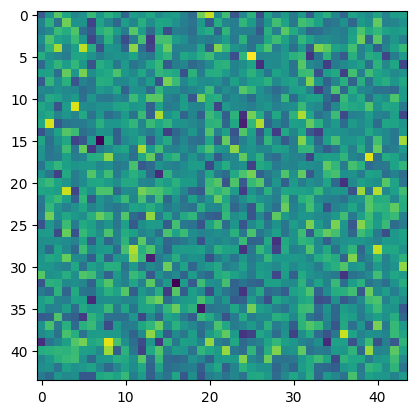

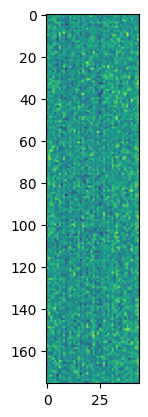

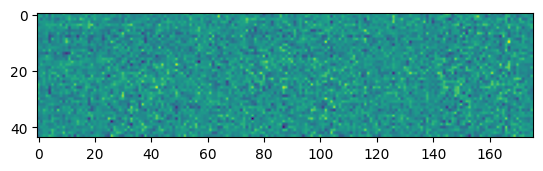

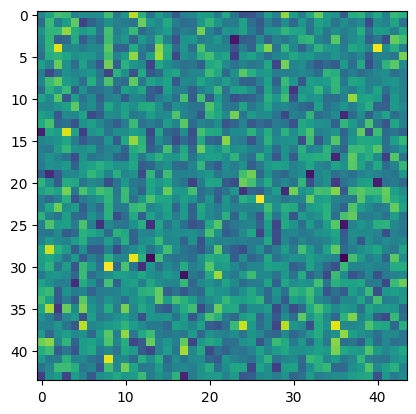

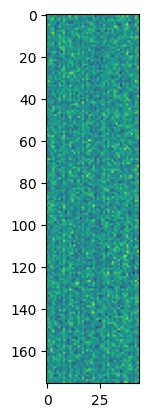

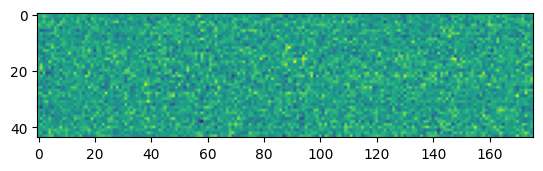

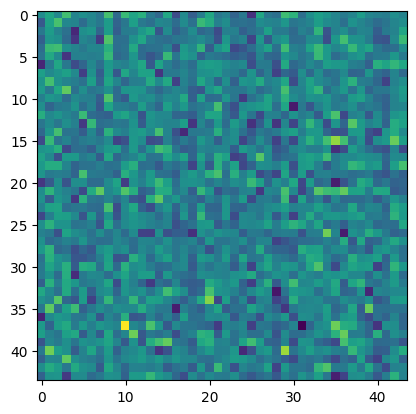

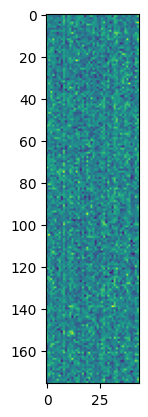

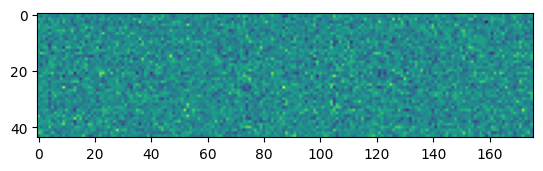

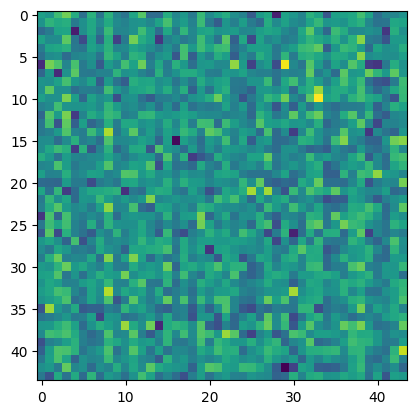

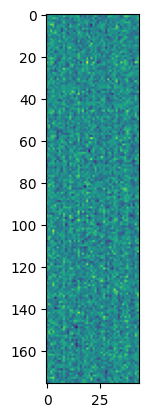

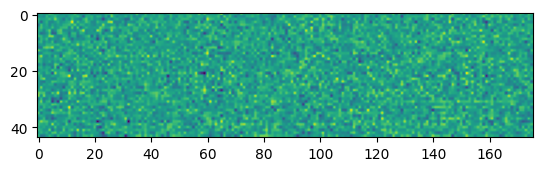

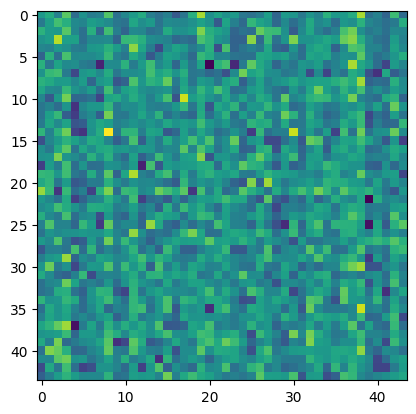

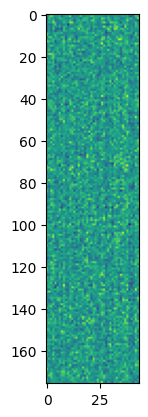

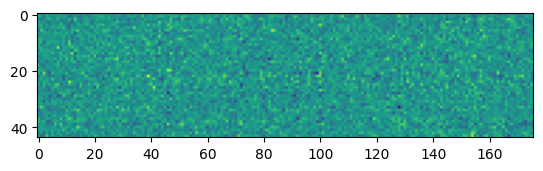

In [18]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [19]:
y = trainer.model.model.generate(torch.tensor([dataset.stoi[s] for s in "O God, O God!".rjust(block_size)]).unsqueeze(0).to(device), 650)
print("".join([dataset.itos[int(i)] for i in y[0]]))

RuntimeError: Placeholder storage has not been allocated on MPS device!